In [1]:
import numpy as np
from scipy import signal
import torch
import json
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.nn import Module
from collections import defaultdict

from GAIL.models.nets import Expert
from GAIL.models.gail import GAIL

from utilities import *
from utilitiesDL import *
torch.set_num_threads(1)

In [2]:
inputJsonFileName = 'test'
LSTMModelDir = './savedModels/selected/'

inputJsonFile = open("./inputJson/varGAIL/" + inputJsonFileName + ".json", "r")
inputJson = json.load(inputJsonFile)
LSTMTargetModelName = inputJson['LSTMTargetModelName']
LSTMSurroModelName = inputJson['LSTMSurroModelName']
noiseAmpRatio = inputJson['noiseAmpRatio']
trDataList = inputJson['trDataList']
trExpDataRatio = inputJson['trExpDataRatio']
nHiddenGAIL = inputJson['nHiddenGAIL']
padLen = inputJson['padLen']
inputLenTime = inputJson['inputLenTime']
outputLenTime = inputJson['outputLenTime']
dSampFactor = inputJson['dSampFactor']
delayLen = inputJson['delayLen']
GAILTrainConfig = inputJson['trainConfig']

cudaID = 5
attackScheme = 'GAIL'
# padLen = 9
if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False
cudaLoc = 'cuda:' + str(cudaID)

dataType = LSTMTargetModelName.split('_')[0]
if dataType == 'TAR':
    fs = 1000 # 1 kHz
    nSubC = 30
    nRX = 3
    
    winLen = 1000
    activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
    # activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']

    targetSingleAct = True
    testAct = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']

print(LSTMSurroModelName, LSTMTargetModelName)
LSTMTargetType = LSTMTargetModelName.split('_')[2]
biDirTarget = (LSTMTargetType == 'BiLSTM')
LSTMSurroType = LSTMSurroModelName.split('_')[2]
biDirSurro = (LSTMSurroType == 'BiLSTM')
nHiddenTarget = int(LSTMTargetModelName.split('_')[4])
nHiddenSurro = int(LSTMSurroModelName.split('_')[4])

# targetWin = (LSTMTargetModelName.split('_')[7] == 'win') # to be corrected!
targetWin = False
saveFileName = LSTMSurroModelName + '_' + inputJsonFileName

# Load target/surro LSTM models
if targetWin:
    HARTargetNet = LSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    seq_length=1000,\
                    device=device)
    dSampRatio = 5
else:
    HARTargetNet = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    device=device)
HARTargetNet.load_state_dict(torch.load(LSTMModelDir + LSTMTargetModelName + '.cpkt', map_location=cudaLoc))

HARSurroNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=biDirSurro,\
                hidden_size=nHiddenSurro,\
                num_layers=1,\
                device=device)
HARSurroNet.load_state_dict(torch.load(LSTMModelDir + LSTMSurroModelName + '.cpkt', map_location=cudaLoc))

# HARNet.to(device)
# Load dataset labelled with FGM attack
FGMdatasetDir = '/project/iarpa/wifiHAR/HAR_' + dataType + '/noWin_dSamp_' + str(dSampFactor) + '_pad_' + str(padLen) + '_FGM/'
print('FGM dataset dir:', 'HAR_' + dataType + '/noWin_dSamp_' + str(dSampFactor) + '_pad_' + str(padLen) + '_FGM/')
dataDict = {file:[] for file in activities}
# tsDataDict = {file:[] for file in activities}

trExpDataset = list()
trAgentDataset = list()
tsDataset = list()
correct = 0.0
nData = 0.0
noiseAmpRatio = 1e-4
# activities = ['walk']
longestLenList = list()
for actInd, activity in enumerate(activities):
    longestLen = 0
    dataDict[activity] = defaultdict(list)

    if not targetSingleAct or activity in testAct:
        dataInputActFileName = FGMdatasetDir + 'input_' + LSTMSurroModelName + '_' + activity + '.npy'
        dataFGMActFileName = FGMdatasetDir + 'FGM_' + LSTMSurroModelName + '_' + activity + '.npy'

        datasetObs = np.load(dataInputActFileName, allow_pickle=True)
        datasetFGM = np.load(dataFGMActFileName, allow_pickle=True)
        for (ob, FGM) in zip(datasetObs, datasetFGM):
            dataDict[activity]['obs'].append(ob)
            dataDict[activity]['FGM'].append(FGM)
            if FGM.shape[0] > longestLen:
                longestLen = FGM.shape[0]
        dataDict[activity]['label'] =\
            (actInd) * torch.ones_like(torch.empty(len(dataDict[activity]['obs']), device=device), dtype=int)
        longestLenList.append(longestLen)
            
        if actInd == 0:
            tsDataList = list(set(range(len(datasetObs))) - set(trDataList))
            trExpDataList = random.sample(trDataList, int(trExpDataRatio*len(trDataList)))
            trAgentDataList = list(set(trDataList) - set(trExpDataList))
        
        datasetAct = FGMDataset(dataDict[activity], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
        tsDataset.append(torch.utils.data.Subset(datasetAct, tsDataList))
        trExpDataset.append(torch.utils.data.Subset(datasetAct, trExpDataList))
        trAgentDataset.append(torch.utils.data.Subset(datasetAct, trAgentDataList))

        print('activity:', activity, 'trExpDataset:', len(trExpDataset[-1]),\
            'trAgentDataset:', len(trAgentDataset[-1]), 'tsDataset:', len(tsDataset[-1]))

trExpLoader = DataLoader(torch.utils.data.ConcatDataset(trExpDataset),\
                      batch_size=1, shuffle=True, generator=torch.Generator(device=device))
trAgentLoader = DataLoader(torch.utils.data.ConcatDataset(trAgentDataset),\
                      batch_size=1, shuffle=True, generator=torch.Generator(device=device))
tsLoader = DataLoader(torch.utils.data.ConcatDataset(tsDataset),\
                      batch_size=1, shuffle=True, generator=torch.Generator(device=device))

correct = .0
for trAgentData in trAgentLoader:
    # print(trAgentData['obs'].shape, trAgentData['FGM'].shape)
    trAgentObs = trAgentData['obs']
    if targetWin:
        trAgentObs = trAgentObs[:, ::dSampRatio, :]
        trAgentObs = trAgentObs * torch.numel(trAgentObs) /\
                (LA.norm(trAgentObs) * nSubC * nRX)
    # print(trAgentObs.shape, trAgentData['FGM'].shape)
    pred, label = getPredsGAIL(trAgentObs, trAgentData['FGM'], trAgentData['label'],\
                                HARSurroNet, noiseAmpRatio, padLen=9)
    correct += (pred == label)
for trExpData in trExpLoader:
    trExpObs = trExpData['obs']
    if targetWin:
        trExpObs = trExpObs[:, ::dSampRatio, :]
        trExpObs = trExpObs * torch.numel(trExpObs) /\
            (LA.norm(trExpObs) * nSubC * nRX)
    pred, label = getPredsGAIL(trExpObs, trExpData['FGM'], trExpData['label'],\
                                HARSurroNet, noiseAmpRatio, padLen=9)
    correct += (pred == label)
print('trExpLoader:', len(trExpLoader), 'trAgentLoader', len(trAgentLoader), 'tsLoader:', len(tsLoader))
print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/(len(trExpLoader)+len(trAgentLoader))), end=' ')
# print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/(len(tsLoader))), end=' ')

print(longestLenList)

TAR_surro_BiLSTM_H_200_dS_10 TAR_target_BiLSTM_H_200_dS_10
FGM dataset dir: HAR_TAR/noWin_dSamp_10_pad_9_FGM/
activity: bed trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
activity: fall trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
activity: run trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
activity: sitdown trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
activity: standup trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
activity: walk trExpDataset: 32 trAgentDataset: 8 tsDataset: 39
trExpLoader: 192 trAgentLoader 48 tsLoader: 234
[0.0001, 0.971] [482, 330, 1131, 344, 323, 1001]


In [3]:
from GAIL.models.nets import PolicyNetwork, ValueNetwork, Discriminator
from GAIL.utils.funcs import get_flat_grads, get_flat_params, set_params, \
    conjugate_gradient, rescale_and_linesearch

if torch.cuda.is_available():
    from torch.cuda import FloatTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor


class varGAIL(Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        nHidden,
        padLen,
        inputLenTime,
        outputLenTime,
        delayLen,
        discrete,
        HARTargetNet,
        device,
        train_config=None
    ) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.nHidden = nHidden
        self.discrete = discrete
        self.padLen = padLen
        self.inputLenTime = inputLenTime
        self.outputLenTime = outputLenTime
        self.delayLen = delayLen
        self.device = device
        self.HARTargetNet = HARTargetNet
        self.train_config = train_config

        self.pi = PolicyNetwork(self.state_dim*self.inputLenTime,\
                                self.action_dim, self.nHidden,\
                                self.discrete, self.device)
        self.v = ValueNetwork(self.state_dim*self.inputLenTime,\
                              self.nHidden, self.device)
        self.d = Discriminator(self.state_dim*self.inputLenTime,\
                            self.action_dim, self.nHidden,\
                            self.discrete, self.device)

    def get_networks(self):
        return [self.pi, self.v]

    def act(self, state):
        self.pi.eval()
        state = FloatTensor(state)
        distb = self.pi(state)
        action = distb.sample()
        # action = distb.sample().detach().cpu().numpy()

        return action
    
    def eval(self, trLoader, pi):
        self.pi.load_state_dict(pi.state_dict())
        self.pi.eval()
        
        nDataTs = 0
        for trData in trLoader:
            nDataTs += trData['obs'].shape[0]

        # noiseAmpRatioList = [5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
        noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

        correct = [0. for _ in noiseAmpRatioList]
        lineBreakCount = 0
        for trData in trLoader:
            seqLength = trData['obs'].shape[1] - padLen
            obsData = torch.Tensor().to(device)
            for inputIndex in range(self.inputLenTime):
                obsData = torch.cat((obsData, trData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)

            obsDataSq = torch.squeeze(obsData, 0)
            actsDataSq = self.act(obsDataSq)
            actsData = torch.unsqueeze(actsDataSq, 0)

            for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                # print(obsData[:, :, -(self.state_dim):].shape, actsData.shape)
                pred, label = getPredsGAIL(obsData[:, :, -(self.state_dim):], actsData, trData['label'],\
                                                self.HARTargetNet, noiseAmpRatio)
                correct[noiseAmpIndex] += (pred == label)

        for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct[noiseAmpIndex]/nDataTs), end=' ')
        
        lineBreakCount += 1
        if lineBreakCount == 5:
            print('')
            lineBreakCount = 0
        if lineBreakCount != 0:
            print('')
        
        acc = [x/nDataTs for x in correct]
        return acc

    def train(self, trExpLoader, trAgentLoader, tsLoader):
        num_iters = self.train_config["num_iters"]
        lambda_ = self.train_config["lambda"]
        gae_gamma = self.train_config["gae_gamma"]
        gae_lambda = self.train_config["gae_lambda"]
        eps = self.train_config["epsilon"]
        max_kl = self.train_config["max_kl"]
        cg_damping = self.train_config["cg_damping"]
        opt_d_LR = self.train_config["opt_d_LR"]
        normalize_advantage = self.train_config["normalize_advantage"]

        opt_d = torch.optim.Adam(self.d.parameters(), lr=opt_d_LR)

        nDataTrExp = 0
        for _ in trExpLoader:
            nDataTrExp += 1
        nDataTrAgent = 0
        for _ in trAgentLoader:
            nDataTrAgent += 1
        nDataTs = 0
        for _ in tsLoader:
            nDataTs += 1
        print('nDataTrExp:', nDataTrExp, 'nDataTrAgent:', nDataTrAgent, 'nDataTs:', int(nDataTs),\
              'inputLen:', inputLenTime, 'outputLen:', outputLenTime)
        
        # noiseAmpRatioList = [5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
        noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

        # print("----White-box attack performance (Expert)----")
        # print('[ampRatio, Acc.]:', end=' ')
        # lineBreakCount = 0
        # for noiseAmpRatio in noiseAmpRatioList:
        #     correct = 0.
        #     for tsData in tsLoader:
        #         tsObswoPad = tsData['obs'][:, padLen:, :]
        #         pred, label = getPredsGAIL(tsObswoPad, tsData['FGM'], tsData['label'],\
        #                                       HARNetTarget, noiseAmpRatio)
        #         # for pred, label in zip(pred_l, label_l):
        #         correct += (pred == label)
        #     print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTs), end=' ')
        #     lineBreakCount += 1
        #     if lineBreakCount == 5:
        #         print('')
        #         lineBreakCount = -2
        # if lineBreakCount > 0:
        #     print('')

        print("----Black-box attack performance----")
        print('[ampRatio, Acc.]:', end=' ')
        lineBreakCount = 0
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            for trAgentData in trAgentLoader:
                trAgentObswoPad = trAgentData['obs'][:, padLen:, :]
                pred, label = getPredsGAIL(trAgentObswoPad, trAgentData['FGM'], trAgentData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            for trExpData in trExpLoader:
                trExpObswoPad = trExpData['obs'][:, padLen:, :]
                pred, label = getPredsGAIL(trExpObswoPad, trExpData['FGM'], trExpData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct/(nDataTrAgent+nDataTrExp)), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = -2
        if lineBreakCount > 0:
            print('')

        print('----Random noise attack performance----')
        print('[ampRatio, Acc.]:', end=' ')
        lineBreakCount = 0
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            for trAgentData in trAgentLoader:
                trAgentObswoPad = trAgentData['obs'][:, padLen:, :]
                noiseData = torch.randn(trAgentObswoPad.shape).to(device)
                pred, label = getPredsGAIL(trAgentObswoPad, noiseData, trAgentData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            for trExpData in trExpLoader:
                trExpObswoPad = trExpData['obs'][:, padLen:, :]
                noiseData = torch.randn(trExpObswoPad.shape).to(device)
                pred, label = getPredsGAIL(trExpObswoPad, noiseData, trExpData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct/(nDataTrAgent+nDataTrExp)), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = -2
        if lineBreakCount > 0:
            print('')

        print("GAIL training starts!")
        bestAcc = 1.0
        accHistory = np.zeros((num_iters, len(noiseAmpRatioList)))
        for iIter in range(num_iters):
            if lineBreakCount > 0 and iIter!= 0:
                print('')
            print('Iter {}'.format(iIter), end=' ')

            obs = []
            acts = []
            rets = []
            advs = []
            gms = []
            agentScores = []

            correct = [0. for _ in noiseAmpRatioList]
            for trAgentData in trAgentLoader:
                seqLength = trAgentData['obs'].shape[1] - padLen
                obsData = torch.Tensor().to(device)
                for inputIndex in range(self.inputLenTime):
                    obsData = torch.cat((obsData, trAgentData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)
                # obsData = torch.cat((obsData, trAgentData['obs'][:, padLen:, :]), dim=2)
                obsDataSq = torch.squeeze(obsData, 0)
                actsDataSq = self.act(obsDataSq)
                actsData = torch.unsqueeze(actsDataSq, 0)

                obs.append(obsDataSq)
                acts.append(actsDataSq)
                agentScores.append(self.d.get_logits(obsDataSq, actsDataSq))

                gmsData = torch.pow(gae_gamma, torch.arange(seqLength)).to(device)
                lmbsData = torch.pow(gae_lambda, torch.arange(seqLength)).to(device)
                costsData = (-1) * torch.log(self.d(obsDataSq, actsDataSq)).squeeze().detach()
                discCostsData = gmsData * costsData
                discRetsData = torch.flip(torch.flip(\
                        discCostsData.to(device), dims=[0]).cumsum(dim=0), dims=[0])
                retsData = discRetsData / gmsData

                self.v.eval()
                currVals = self.v(obsDataSq).detach()
                nextVals = torch.cat((self.v(obsDataSq)[1:], torch.zeros(1, 1, device=device)))
                deltasData = costsData.unsqueeze(-1) + gae_gamma * nextVals - currVals
                advsData = FloatTensor([
                        ((gmsData * lmbsData)[:seqLength - j].unsqueeze(-1) * deltasData[j:]).sum()
                        for j in range(seqLength)]).to(device)
                
                gms.append(gmsData)
                rets.append(retsData)
                advs.append(advsData)
                # print(currVals.shape, nextVals.shape, deltasData.shape, advsData.shape)

                for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                    pred, label = getPredsGAIL(trAgentData['obs'][:, padLen:,:],\
                                            actsData,\
                                            trAgentData['label'],\
                                            HARTargetNet,\
                                            noiseAmpRatio)
                    # print(pred_l, label_l)
                    # for pred, label in zip(pred_l, label_l):
                    correct[noiseAmpIndex] += (pred == label)
                    # print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')

            if normalize_advantage:
                advFlatten = torch.Tensor().to(device)
                for adv in advs:
                    advFlatten = torch.cat((advFlatten, adv))

                advFlatten = (advFlatten - advFlatten.mean()) / advFlatten.std()
                cumIndex = 0
                
                advsNorm = []
                for adv in advs:
                    advsNorm.append(advFlatten[cumIndex:cumIndex+len(adv)])
                    cumIndex += len(adv)
                advs = advsNorm

            self.d.train()
            expObs = []
            expActs = []
            expScores = []
            for trExpData in trExpLoader:
                seqLength = trExpData['obs'].shape[1] - padLen
                expObsData = torch.Tensor().to(device)
                for inputIndex in range(self.inputLenTime):
                    expObsData = torch.cat((expObsData, trExpData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)
                # expObsData = torch.cat((expObsData, trExpData['obs'][:, padLen:, :]), dim=2)
                expObsDataSq = torch.squeeze(expObsData, 0)
                expActsDataSq = self.act(expObsDataSq)

                expObs.append(expObsDataSq)
                expActs.append(expActsDataSq)
                expScores.append(self.d.get_logits(expObsDataSq, expActsDataSq))
            
            opt_d.zero_grad()
            lossAgent = 0
            meanScoreAgent = []
            for agentScore in agentScores:
                lossAgent += torch.nn.functional.binary_cross_entropy_with_logits(\
                    agentScore, torch.ones_like(agentScore))
                meanScoreAgent.append(agentScore.mean().item())
            lossExp = 0
            meanScoreExp = []
            for expScore in expScores:
                lossExp += torch.nn.functional.binary_cross_entropy_with_logits(\
                    expScore, torch.zeros_like(expScore))
                meanScoreExp.append(expScore.mean().item())
            loss = (lossAgent / len(agentScores)) + (lossExp / len(expScores))
            loss.backward()
            opt_d.step()
            
            print('scores: {0:.3f}, {1:.3f}'.format\
                  ((sum(meanScoreAgent) / len(meanScoreAgent)), (sum(meanScoreExp) / len(meanScoreExp))), end=' ')

            del expScores, agentScores

            self.v.train()
            vList = []
            for obsData, retsData in zip(obs, rets):
                old_params = get_flat_params(self.v).detach()
                old_v = self.v(obsData).detach()

                def constraint():
                    return ((old_v - self.v(obsData)) ** 2).mean()

                grad_diff = get_flat_grads(constraint(), self.v)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_diff, v), self.v).detach()
                    return hessian

                g = get_flat_grads(
                    ((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean(), self.v).detach()
                vList.append(((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean().item())

                s = conjugate_gradient(Hv, g).detach()

                Hs = Hv(s).detach()
                alpha = torch.sqrt(2 * eps / torch.dot(s, Hs))
                # print('alpha:', alpha, 's:', s[:10])

                new_params = old_params + alpha * s

                # print('v:', ((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean())
                set_params(self.v, new_params)
            
            print('v: {0:.1f}'.format(sum(vList)/len(vList)), end=' ')


            # print(obs.shape, acts.shape, rets.shape, advs.shape, gms.shape)
            self.pi.train()
            for obsData, actsData, advsData, gmsData in zip(obs, acts, advs, gms):
                old_params = get_flat_params(self.pi).detach()
                old_distb = self.pi(obsData)

                def L():
                    distb = self.pi(obsData)
                    return (advsData * torch.exp(distb.log_prob(actsData)
                                - old_distb.log_prob(actsData).detach())).mean()

                def kld():
                    distb = self.pi(obsData)
                    old_mean = old_distb.mean.detach()
                    old_cov = old_distb.covariance_matrix.sum(-1).detach()
                    mean = distb.mean
                    cov = distb.covariance_matrix.sum(-1)
                    return (0.5) * ((old_cov / cov).sum(-1)
                            + (((old_mean - mean) ** 2) / cov).sum(-1)
                            - self.action_dim
                            + torch.log(cov).sum(-1)
                            - torch.log(old_cov).sum(-1)).mean()

                grad_kld_old_param = get_flat_grads(kld(), self.pi)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_kld_old_param, v), self.pi).detach()
                    return hessian + cg_damping * v

                g = get_flat_grads(L(), self.pi).detach()
                s = conjugate_gradient(Hv, g).detach()
                Hs = Hv(s).detach()
                new_params = rescale_and_linesearch(g, s, Hs, max_kl, L, kld, old_params, self.pi)
                # print('new_params:', new_params.mean(), obs.shape, acts.shape)
            
                disc_causal_entropy = ((-1) * gmsData * self.pi(obsData).log_prob(actsData)).mean()
                grad_disc_causal_entropy = get_flat_grads(disc_causal_entropy, self.pi)
                new_params += lambda_ * grad_disc_causal_entropy
                set_params(self.pi, new_params)

            print('[ampRatio, Acc.]:', end=' ')
            lineBreakCount = 0
            ampSaveCriterion = 0.1
            for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                print('[{0}, {1:.3f}]'.\
                        format(noiseAmpRatio, correct[noiseAmpIndex]/nDataTrAgent), end=' ')
                accHistory[iIter, noiseAmpIndex] = correct[noiseAmpIndex]/nDataTrAgent

                lineBreakCount += 1
                if lineBreakCount == 5:
                    print('')
                    lineBreakCount = -2

            with open('./savedModels/GAIL/logs/' + saveFileName + '_accHistory.npy', 'wb') as f:
                # print(iIter, end=' ')
                # print(accHistory[iIter, :])
                np.save(f, accHistory)

            compAmpRatio = np.where(np.array(noiseAmpRatioList) == ampSaveCriterion)[0][0]
            if correct[compAmpRatio]/nDataTrAgent < bestAcc:
                bestAcc = correct[compAmpRatio]/nDataTrAgent
                torch.save(self.pi.state_dict(), './savedModels/varGAIL/' + saveFileName + '_pi.cpkt')
                torch.save(self.v.state_dict(), './savedModels/varGAIL/' + saveFileName + '_v.cpkt')
                torch.save(self.d.state_dict(), './savedModels/varGAIL/' + saveFileName + '_d.cpkt')
                print('model saved!', end=' ')

            # print('log_prob:', self.pi(obs).log_prob(acts).mean().item(), 'grad_disc:', grad_disc_causal_entropy.mean(), 'disc_ent:', disc_causal_entropy.item())
            # # print('pi:', new_params.norm().item(), lambda_, grad_disc_causal_entropy.norm().item())
            # print('iter final v:', self.v.net[0].weight[1, :5].squeeze().detach().cpu().numpy())
            # print('iter final pi:', self.pi.net[0].weight[1, :5].squeeze().detach().cpu().numpy())
        return _

In [15]:
targetSingleAct = True
nHiddenGAIL = 200
LRstr = '5e-6'
inputLenTime = 5
outputLenTime = 1
pi = PolicyNetwork(nSubC*nRX*inputLenTime, nSubC*nRX*outputLenTime, nHiddenGAIL, False, device)

dSampFactor = 10
activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
# GAILConfigName = 'GAILConfig01_LRe-3'
# noiseAmpRatioList = [1e-5, 5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
# noiseAmpRatio = 0.1
accTotalList = [0] * len(noiseAmpRatioList)
if targetSingleAct:
    accList = [] * len(noiseAmpRatioList)
    for testAct in activities:
        GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_dLen_' + str(delayLen) +  '_iL_' + str(inputLenTime) + '_' + testAct
        print(LSTMSurroModelName, GAILConfigName, end=' ')
        pi.load_state_dict(torch.load('./savedModels/varGAIL/' + LSTMSurroModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))

        trDatasetAct = list()
        tsDatasetAct = list()
        datasetAct = FGMDataset(dataDict[testAct], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
        trDatasetAct.append(torch.utils.data.Subset(datasetAct, list(trDataList)))
        tsDatasetAct.append(torch.utils.data.Subset(datasetAct, list(set(range(len(datasetAct))) - set(trDataList))))

        print('totalData:', len(datasetAct), 'tsDatasetAct:', len(trDatasetAct[-1]))

        trLoaderAct = DataLoader(torch.utils.data.ConcatDataset(tsDatasetAct),\
                            batch_size=1, shuffle=True, generator=torch.Generator(device=device))
        GAILEvalModel = varGAIL(state_dim=nSubC*nRX,\
                    action_dim=nSubC*nRX,\
                    nHidden=nHiddenGAIL,\
                    padLen=padLen,\
                    inputLenTime=inputLenTime,\
                    outputLenTime=outputLenTime,\
                    delayLen=delayLen,\
                    discrete=False,\
                    HARTargetNet=HARTargetNet,\
                    device=device,\
                    train_config=GAILTrainConfig)

        nEval = 3
        for _ in range(nEval):
            accList = GAILEvalModel.eval(trLoaderAct, pi)
            accTotalList = [accTotalList[i] + accList[i] for i in range(len(accList))]
    for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
        print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*accTotalList[noiseAmpIndex]/(len(activities)*nEval)), end=' ')
else:
    GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_iL_' + str(inputLenTime)
    # GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr
    print(LSTMModelName, GAILConfigName)

    pi.load_state_dict(torch.load('./savedModels/varGAIL/' + LSTMModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))
    GAILEvalModel = varGAIL(state_dim=nSubC*nRX,\
                action_dim=nSubC*nRX,\
                nHidden=nHiddenGAIL,\
                padLen=padLen,\
                inputLenTime=inputLenTime,\
                outputLenTime=outputLenTime,\
                discrete=False,\
                device=device,\
                train_config=GAILTrainConfig)

    nEval = 3
    for _ in range(nEval):
        GAILEvalModel.eval(tsLoader, pi)

TAR_surro_BiLSTM_H_200_dS_10 nH_200_dS_10_LR_5e-6_dLen_1_iL_5_bed totalData: 79 tsDatasetAct: 40
[1e-06, 95.0] [0.001, 95.0] [0.002, 95.0] [0.005, 95.0] [0.01, 95.0] [0.02, 95.0] [0.05, 95.0] [0.1, 90.0] [0.2, 77.5] [0.5, 32.5] [1, 0.0] [2, 0.0] [5, 10.0] [10, 32.5] 
[1e-06, 95.0] [0.001, 95.0] [0.002, 95.0] [0.005, 95.0] [0.01, 95.0] [0.02, 95.0] [0.05, 95.0] [0.1, 90.0] [0.2, 80.0] [0.5, 20.0] [1, 0.0] [2, 0.0] [5, 17.5] [10, 35.0] 
[1e-06, 95.0] [0.001, 95.0] [0.002, 95.0] [0.005, 95.0] [0.01, 95.0] [0.02, 95.0] [0.05, 95.0] [0.1, 87.5] [0.2, 75.0] [0.5, 25.0] [1, 0.0] [2, 0.0] [5, 17.5] [10, 25.0] 
TAR_surro_BiLSTM_H_200_dS_10 nH_200_dS_10_LR_5e-6_dLen_1_iL_5_fall totalData: 79 tsDatasetAct: 40
[1e-06, 97.5] [0.001, 97.5] [0.002, 97.5] [0.005, 97.5] [0.01, 97.5] [0.02, 97.5] [0.05, 100.0] [0.1, 95.0] [0.2, 75.0] [0.5, 5.0] [1, 0.0] [2, 0.0] [5, 0.0] [10, 2.5] 
[1e-06, 97.5] [0.001, 97.5] [0.002, 97.5] [0.005, 97.5] [0.01, 97.5] [0.02, 97.5] [0.05, 97.5] [0.1, 95.0] [0.2, 77.5] [0.5

In [ ]:
attackScheme = 'GAIL' # FGM, Univ GAIL

LRstr = '2e-5'
inputLenTime = 5
dSampSurro = 10
dSampTarget = 2
noiseAmpRatio = 0.1
slideLen = 200
seqLen = 1000
pi = PolicyNetwork(nSubC*nRX*inputLenTime, nSubC*nRX*outputLenTime, nHiddenGAIL, False, device)
GAILEvalModel = varGAIL(state_dim=nSubC*nRX,\
            action_dim=nSubC*nRX,\
            nHidden=nHiddenGAIL,\
            padLen=padLen,\
            inputLenTime=inputLenTime,\
            outputLenTime=outputLenTime,\
            delayLen=delayLen,\
            discrete=False,\
            HARTargetNet=HARTargetNet,\
            device=device,\
            train_config=GAILTrainConfig)

if attackScheme == 'Univ':
    for actInd, activity in enumerate(activities):
        totalDatasetAct = FGMDataset(dataDict[activity], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
        totalDataset = list()
        totalDataset.append(torch.utils.data.Subset(totalDatasetAct, range(len(totalDatasetAct))))
        totalLoader = DataLoader(torch.utils.data.ConcatDataset(totalDataset),\
                        batch_size=1, shuffle=False, generator=torch.Generator(device=device))

    avgActsDataList = list()
    for actInd, activity in enumerate(activities):
        avgActsData = torch.zeros((1, longestLenList[actInd], nSubC*nRX)).to(device)
        for data in totalLoader:
            actsData = data['FGM']
            # print(actsData.shape)
            actsDataRes = signal.resample_poly(actsData.cpu(), longestLenList[actInd], actsData.shape[1], axis=1)
            # print(avgActsData.shape, actsDataRes.shape)
            avgActsData += torch.Tensor(actsDataRes).to(device)
        avgActsData /= len(totalLoader)
        avgActsDataList.append(avgActsData)

for actInd, activity in enumerate(activities):
    print(activity)
    inputList = []
    actsList = []

    totalDatasetAct = FGMDataset(dataDict[activity], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
    totalDataset = list()
    totalDataset.append(torch.utils.data.Subset(totalDatasetAct, range(len(totalDatasetAct))))
    totalLoader = DataLoader(torch.utils.data.ConcatDataset(totalDataset),\
                    batch_size=1, shuffle=False, generator=torch.Generator(device=device))
    
    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_TAR/win_dSamp_" +\
        str(dSampTarget)+ "_" + attackScheme + "/input_" + LSTMSurroModelName + "_" + activity
    dataFGM_fileName = "/project/iarpa/wifiHAR/HAR_TAR/win_dSamp_" +\
        str(dSampTarget)+ "_" + attackScheme + "/" + attackScheme + "_" + LSTMSurroModelName + "_" + activity
    
    GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampSurro) + '_LR_' + LRstr + '_dLen_' + str(delayLen) +  '_iL_' + str(inputLenTime) + '_' + activity
    pi.load_state_dict(torch.load('./savedModels/varGAIL/' + LSTMSurroModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))

    for data in totalLoader:
        seqLength = data['obs'].shape[1] - padLen
        obsData = torch.Tensor().to(device)
        for inputIndex in range(inputLenTime):
            obsData = torch.cat((obsData, data['obs']\
                        [:, padLen - inputLenTime + inputIndex - delayLen + 1:\
                        padLen - inputLenTime + inputIndex - delayLen + seqLength + 1:int(dSampSurro/dSampTarget), :]), dim=2)

        dataWoPad = data['obs'][:, padLen:, :]

        if attackScheme == 'FGM':
            actsData = data['FGM']
            # actsData = data['FGM'][:, padLen:, :]
            actsDataUSamp = torch.Tensor().to(device)
            for uSampIdx, tIdx in enumerate(range(0, dataWoPad.shape[1], int(dSampSurro/dSampTarget))):
                actsTimeSamp = actsData[:, uSampIdx, :]
                actsDataUSamp = torch.cat((actsDataUSamp, actsTimeSamp.repeat(1, 5, 1)), dim=1)
            actsDataUSamp = actsDataUSamp[:, :dataWoPad.shape[1], :]
            # print(actsDataUSamp.shape)
        
        elif attackScheme == 'Univ':
            actsData = torch.from_numpy(signal.resample_poly(avgActsDataList[actInd].cpu(), data['FGM'].shape[1], longestLenList[actInd], axis=1)).to(device)
            # print(actsData.shape, dataWoPad.shape, data['FGM'].shape, avgActsDataList[actInd].shape, longestLenList[actInd], actInd)
            actsDataUSamp = torch.Tensor().to(device)
            for uSampIdx, tIdx in enumerate(range(0, dataWoPad.shape[1], int(dSampSurro/dSampTarget))):
                actsTimeSamp = actsData[:, uSampIdx, :]
                actsDataUSamp = torch.cat((actsDataUSamp, actsTimeSamp.repeat(1, 5, 1)), dim=1)
            actsDataUSamp = actsDataUSamp[:, :dataWoPad.shape[1], :]
            # print(actsDataUSamp.shape)

        elif attackScheme == 'GAIL':
            obsDataSq = torch.squeeze(obsData, 0)
            actsDataSq = GAILEvalModel.act(obsDataSq)
            actsData = torch.unsqueeze(actsDataSq, 0)
            actsDataUSamp = torch.Tensor().to(device)
            for uSampIdx, tIdx in enumerate(range(0, dataWoPad.shape[1], int(dSampSurro/dSampTarget))):
                actsTimeSamp = actsData[:, uSampIdx, :]
                # print(actsTimeSamp.repeat(1, 5, 1).shape)
                actsDataUSamp = torch.cat((actsDataUSamp, actsTimeSamp.repeat(1, 5, 1)), dim=1)
            actsDataUSamp = actsDataUSamp[:, :dataWoPad.shape[1], :]
            
        # obsWGAIL = data['obs'][:,padLen:,:] + actsDataUSamp
        
        # if attackScheme == 'FGM' or attackScheme == 'GAIL':
        for tIdx in range(0, dataWoPad.shape[1], slideLen):
            inputWin = dataWoPad[:, tIdx:tIdx+seqLen, :]
            actsWin = actsDataUSamp[:, tIdx:tIdx+seqLen, :]
            if inputWin.shape[1] < seqLen:
                continue

            noiseAmp = LA.norm(torch.flatten(inputWin)) * noiseAmpRatio
            noiseFlatten = torch.flatten(actsWin)
            noiseNormalized = torch.mul(torch.div(noiseFlatten,\
                LA.norm(noiseFlatten)), noiseAmp)
            actsWin = noiseNormalized.view(inputWin.shape)

            inputList.append(torch.squeeze(inputWin).cpu().detach())
            actsList.append(torch.squeeze(actsWin).cpu().detach())
        # print(actsDataUSamp.shape, data['obs'].shape[1]-padLen)

        # print(data['obs'][:, padLen:, :].shape, actsData.shape, data['FGM'].shape)
    if attackScheme == 'Univ':
        actsDataUSamp = torch.Tensor().to(device)
        for uSampIdx, tIdx in enumerate(range(0, dataWoPad.shape[1], int(dSampSurro/dSampTarget))):
            actsTimeSamp = actsData[:, uSampIdx, :]
            actsDataUSamp = torch.cat((actsDataUSamp, actsTimeSamp.repeat(1, 5, 1)), dim=1)
        actsDataUSamp = actsDataUSamp[:, :dataWoPad.shape[1], :]

    np.save(dataInput_fileName, np.array(inputList, dtype=object), allow_pickle=True)
    np.save(dataFGM_fileName, np.array(actsList, dtype=object), allow_pickle=True)

bed


/tmp/ipykernel_3471371/2820448606.py:130: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save(dataInput_fileName, np.array(inputList, dtype=object), allow_pickle=True)
/tmp/ipykernel_3471371/2820448606.py:131: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or ass

fall
run


KeyboardInterrupt: 

In [8]:
from GAIL.models.nets import PolicyNetwork, ValueNetwork, Discriminator
from GAIL.utils.funcs import get_flat_grads, get_flat_params, set_params, \
    conjugate_gradient, rescale_and_linesearch

if torch.cuda.is_available():
    from torch.cuda import FloatTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor


class varGAIL(Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        nHidden,
        padLen,
        inputLenTime,
        outputLenTime,
        delayLen,
        discrete,
        HARTargetNet,
        device,
        train_config=None
    ) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.nHidden = nHidden
        self.discrete = discrete
        self.padLen = padLen
        self.inputLenTime = inputLenTime
        self.outputLenTime = outputLenTime
        self.delayLen = delayLen
        self.device = device
        self.HARTargetNet = HARTargetNet
        self.train_config = train_config

        self.pi = PolicyNetwork(self.state_dim*self.inputLenTime,\
                                self.action_dim, self.nHidden,\
                                self.discrete, self.device)
        self.v = ValueNetwork(self.state_dim*self.inputLenTime,\
                              self.nHidden, self.device)
        self.d = Discriminator(self.state_dim*self.inputLenTime,\
                            self.action_dim, self.nHidden,\
                            self.discrete, self.device)

    def get_networks(self):
        return [self.pi, self.v]

    def act(self, state):
        self.pi.eval()
        state = FloatTensor(state)
        distb = self.pi(state)
        action = distb.sample()
        # action = distb.sample().detach().cpu().numpy()

        return action
    
    def eval(self, trLoader, pi):
        self.pi.load_state_dict(pi.state_dict())
        self.pi.eval()
        
        nDataTs = 0
        for trData in trLoader:
            nDataTs += trData['obs'].shape[0]

        # noiseAmpRatioList = [5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
        noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

        correct = [0. for _ in noiseAmpRatioList]
        lineBreakCount = 0
        for trData in trLoader:
            seqLength = trData['obs'].shape[1] - padLen
            obsData = torch.Tensor().to(device)
            for inputIndex in range(self.inputLenTime):
                obsData = torch.cat((obsData, trData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)

            obsDataSq = torch.squeeze(obsData, 0)
            actsDataSq = self.act(obsDataSq)
            actsData = torch.unsqueeze(actsDataSq, 0)

            for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                print(obsData[:, :, -(self.state_dim):].shape, actsData.shape)
                pred, label = getPredsGAIL(obsData[:, :, -(self.state_dim):], actsData, trData['label'],\
                                                self.HARTargetNet, noiseAmpRatio)
                correct[noiseAmpIndex] += (pred == label)

        for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct[noiseAmpIndex]/nDataTs), end=' ')
        
        lineBreakCount += 1
        if lineBreakCount == 5:
            print('')
            lineBreakCount = 0
        if lineBreakCount != 0:
            print('')
        
        acc = [x/nDataTs for x in correct]
        return acc

    def train(self, trExpLoader, trAgentLoader, tsLoader):
        num_iters = self.train_config["num_iters"]
        lambda_ = self.train_config["lambda"]
        gae_gamma = self.train_config["gae_gamma"]
        gae_lambda = self.train_config["gae_lambda"]
        eps = self.train_config["epsilon"]
        max_kl = self.train_config["max_kl"]
        cg_damping = self.train_config["cg_damping"]
        opt_d_LR = self.train_config["opt_d_LR"]
        normalize_advantage = self.train_config["normalize_advantage"]

        opt_d = torch.optim.Adam(self.d.parameters(), lr=opt_d_LR)

        nDataTrExp = 0
        for _ in trExpLoader:
            nDataTrExp += 1
        nDataTrAgent = 0
        for _ in trAgentLoader:
            nDataTrAgent += 1
        nDataTs = 0
        for _ in tsLoader:
            nDataTs += 1
        print('nDataTrExp:', nDataTrExp, 'nDataTrAgent:', nDataTrAgent, 'nDataTs:', int(nDataTs),\
              'inputLen:', inputLenTime, 'outputLen:', outputLenTime)
        
        # noiseAmpRatioList = [5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
        noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

        # print("----White-box attack performance (Expert)----")
        # print('[ampRatio, Acc.]:', end=' ')
        # lineBreakCount = 0
        # for noiseAmpRatio in noiseAmpRatioList:
        #     correct = 0.
        #     for tsData in tsLoader:
        #         tsObswoPad = tsData['obs'][:, padLen:, :]
        #         pred, label = getPredsGAIL(tsObswoPad, tsData['FGM'], tsData['label'],\
        #                                       HARNetTarget, noiseAmpRatio)
        #         # for pred, label in zip(pred_l, label_l):
        #         correct += (pred == label)
        #     print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTs), end=' ')
        #     lineBreakCount += 1
        #     if lineBreakCount == 5:
        #         print('')
        #         lineBreakCount = -2
        # if lineBreakCount > 0:
        #     print('')

        print("----Black-box attack performance----")
        print('[ampRatio, Acc.]:', end=' ')
        lineBreakCount = 0
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            for trAgentData in trAgentLoader:
                trAgentObswoPad = trAgentData['obs'][:, padLen:, :]
                pred, label = getPredsGAIL(trAgentObswoPad, trAgentData['FGM'], trAgentData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            for trExpData in trExpLoader:
                trExpObswoPad = trExpData['obs'][:, padLen:, :]
                pred, label = getPredsGAIL(trExpObswoPad, trExpData['FGM'], trExpData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct/(nDataTrAgent+nDataTrExp)), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = -2
        if lineBreakCount > 0:
            print('')

        print('----Random noise attack performance----')
        print('[ampRatio, Acc.]:', end=' ')
        lineBreakCount = 0
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            for trAgentData in trAgentLoader:
                trAgentObswoPad = trAgentData['obs'][:, padLen:, :]
                noiseData = torch.randn(trAgentObswoPad.shape).to(device)
                pred, label = getPredsGAIL(trAgentObswoPad, noiseData, trAgentData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            for trExpData in trExpLoader:
                trExpObswoPad = trExpData['obs'][:, padLen:, :]
                noiseData = torch.randn(trExpObswoPad.shape).to(device)
                pred, label = getPredsGAIL(trExpObswoPad, noiseData, trExpData['label'],\
                                            self.HARTargetNet, noiseAmpRatio)
                correct += (pred == label)
            print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*correct/(nDataTrAgent+nDataTrExp)), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = -2
        if lineBreakCount > 0:
            print('')

        print("GAIL training starts!")
        bestAcc = 1.0
        accHistory = np.zeros((num_iters, len(noiseAmpRatioList)))
        for iIter in range(num_iters):
            if lineBreakCount > 0 and iIter!= 0:
                print('')
            print('Iter {}'.format(iIter), end=' ')

            obs = []
            acts = []
            rets = []
            advs = []
            gms = []
            agentScores = []

            correct = [0. for _ in noiseAmpRatioList]
            for trAgentData in trAgentLoader:
                seqLength = trAgentData['obs'].shape[1] - padLen
                obsData = torch.Tensor().to(device)
                for inputIndex in range(self.inputLenTime):
                    obsData = torch.cat((obsData, trAgentData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)
                # obsData = torch.cat((obsData, trAgentData['obs'][:, padLen:, :]), dim=2)
                obsDataSq = torch.squeeze(obsData, 0)
                actsDataSq = self.act(obsDataSq)
                actsData = torch.unsqueeze(actsDataSq, 0)

                obs.append(obsDataSq)
                acts.append(actsDataSq)
                agentScores.append(self.d.get_logits(obsDataSq, actsDataSq))

                gmsData = torch.pow(gae_gamma, torch.arange(seqLength)).to(device)
                lmbsData = torch.pow(gae_lambda, torch.arange(seqLength)).to(device)
                costsData = (-1) * torch.log(self.d(obsDataSq, actsDataSq)).squeeze().detach()
                discCostsData = gmsData * costsData
                discRetsData = torch.flip(torch.flip(\
                        discCostsData.to(device), dims=[0]).cumsum(dim=0), dims=[0])
                retsData = discRetsData / gmsData

                self.v.eval()
                currVals = self.v(obsDataSq).detach()
                nextVals = torch.cat((self.v(obsDataSq)[1:], torch.zeros(1, 1, device=device)))
                deltasData = costsData.unsqueeze(-1) + gae_gamma * nextVals - currVals
                advsData = FloatTensor([
                        ((gmsData * lmbsData)[:seqLength - j].unsqueeze(-1) * deltasData[j:]).sum()
                        for j in range(seqLength)]).to(device)
                
                gms.append(gmsData)
                rets.append(retsData)
                advs.append(advsData)
                # print(currVals.shape, nextVals.shape, deltasData.shape, advsData.shape)

                for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                    pred, label = getPredsGAIL(trAgentData['obs'][:, padLen:,:],\
                                            actsData,\
                                            trAgentData['label'],\
                                            HARTargetNet,\
                                            noiseAmpRatio)
                    # print(pred_l, label_l)
                    # for pred, label in zip(pred_l, label_l):
                    correct[noiseAmpIndex] += (pred == label)
                    # print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')

            if normalize_advantage:
                advFlatten = torch.Tensor().to(device)
                for adv in advs:
                    advFlatten = torch.cat((advFlatten, adv))

                advFlatten = (advFlatten - advFlatten.mean()) / advFlatten.std()
                cumIndex = 0
                
                advsNorm = []
                for adv in advs:
                    advsNorm.append(advFlatten[cumIndex:cumIndex+len(adv)])
                    cumIndex += len(adv)
                advs = advsNorm

            self.d.train()
            expObs = []
            expActs = []
            expScores = []
            for trExpData in trExpLoader:
                seqLength = trExpData['obs'].shape[1] - padLen
                expObsData = torch.Tensor().to(device)
                for inputIndex in range(self.inputLenTime):
                    expObsData = torch.cat((expObsData, trExpData['obs']\
                            [:, padLen - self.inputLenTime + inputIndex - self.delayLen + 1:\
                            padLen - self.inputLenTime + inputIndex - self.delayLen + seqLength + 1, :]), dim=2)
                # expObsData = torch.cat((expObsData, trExpData['obs'][:, padLen:, :]), dim=2)
                expObsDataSq = torch.squeeze(expObsData, 0)
                expActsDataSq = self.act(expObsDataSq)

                expObs.append(expObsDataSq)
                expActs.append(expActsDataSq)
                expScores.append(self.d.get_logits(expObsDataSq, expActsDataSq))
            
            opt_d.zero_grad()
            lossAgent = 0
            meanScoreAgent = []
            for agentScore in agentScores:
                lossAgent += torch.nn.functional.binary_cross_entropy_with_logits(\
                    agentScore, torch.ones_like(agentScore))
                meanScoreAgent.append(agentScore.mean().item())
            lossExp = 0
            meanScoreExp = []
            for expScore in expScores:
                lossExp += torch.nn.functional.binary_cross_entropy_with_logits(\
                    expScore, torch.zeros_like(expScore))
                meanScoreExp.append(expScore.mean().item())
            loss = (lossAgent / len(agentScores)) + (lossExp / len(expScores))
            loss.backward()
            opt_d.step()
            
            print('scores: {0:.3f}, {1:.3f}'.format\
                  ((sum(meanScoreAgent) / len(meanScoreAgent)), (sum(meanScoreExp) / len(meanScoreExp))), end=' ')

            del expScores, agentScores

            self.v.train()
            vList = []
            for obsData, retsData in zip(obs, rets):
                old_params = get_flat_params(self.v).detach()
                old_v = self.v(obsData).detach()

                def constraint():
                    return ((old_v - self.v(obsData)) ** 2).mean()

                grad_diff = get_flat_grads(constraint(), self.v)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_diff, v), self.v).detach()
                    return hessian

                g = get_flat_grads(
                    ((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean(), self.v).detach()
                vList.append(((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean().item())

                s = conjugate_gradient(Hv, g).detach()

                Hs = Hv(s).detach()
                alpha = torch.sqrt(2 * eps / torch.dot(s, Hs))
                # print('alpha:', alpha, 's:', s[:10])

                new_params = old_params + alpha * s

                # print('v:', ((-1) * (self.v(obsData).squeeze() - retsData) ** 2).mean())
                set_params(self.v, new_params)
            
            print('v: {0:.1f}'.format(sum(vList)/len(vList)), end=' ')


            # print(obs.shape, acts.shape, rets.shape, advs.shape, gms.shape)
            self.pi.train()
            for obsData, actsData, advsData, gmsData in zip(obs, acts, advs, gms):
                old_params = get_flat_params(self.pi).detach()
                old_distb = self.pi(obsData)

                def L():
                    distb = self.pi(obsData)
                    return (advsData * torch.exp(distb.log_prob(actsData)
                                - old_distb.log_prob(actsData).detach())).mean()

                def kld():
                    distb = self.pi(obsData)
                    old_mean = old_distb.mean.detach()
                    old_cov = old_distb.covariance_matrix.sum(-1).detach()
                    mean = distb.mean
                    cov = distb.covariance_matrix.sum(-1)
                    return (0.5) * ((old_cov / cov).sum(-1)
                            + (((old_mean - mean) ** 2) / cov).sum(-1)
                            - self.action_dim
                            + torch.log(cov).sum(-1)
                            - torch.log(old_cov).sum(-1)).mean()

                grad_kld_old_param = get_flat_grads(kld(), self.pi)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_kld_old_param, v), self.pi).detach()
                    return hessian + cg_damping * v

                g = get_flat_grads(L(), self.pi).detach()
                s = conjugate_gradient(Hv, g).detach()
                Hs = Hv(s).detach()
                new_params = rescale_and_linesearch(g, s, Hs, max_kl, L, kld, old_params, self.pi)
                # print('new_params:', new_params.mean(), obs.shape, acts.shape)
            
                disc_causal_entropy = ((-1) * gmsData * self.pi(obsData).log_prob(actsData)).mean()
                grad_disc_causal_entropy = get_flat_grads(disc_causal_entropy, self.pi)
                new_params += lambda_ * grad_disc_causal_entropy
                set_params(self.pi, new_params)

            print('[ampRatio, Acc.]:', end=' ')
            lineBreakCount = 0
            ampSaveCriterion = 0.1
            for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                print('[{0}, {1:.3f}]'.\
                        format(noiseAmpRatio, correct[noiseAmpIndex]/nDataTrAgent), end=' ')
                accHistory[iIter, noiseAmpIndex] = correct[noiseAmpIndex]/nDataTrAgent

                lineBreakCount += 1
                if lineBreakCount == 5:
                    print('')
                    lineBreakCount = -2

            with open('./savedModels/GAIL/logs/' + saveFileName + '_accHistory.npy', 'wb') as f:
                # print(iIter, end=' ')
                # print(accHistory[iIter, :])
                np.save(f, accHistory)

            compAmpRatio = np.where(np.array(noiseAmpRatioList) == ampSaveCriterion)[0][0]
            if correct[compAmpRatio]/nDataTrAgent < bestAcc:
                bestAcc = correct[compAmpRatio]/nDataTrAgent
                torch.save(self.pi.state_dict(), './savedModels/varGAIL/' + saveFileName + '_pi.cpkt')
                torch.save(self.v.state_dict(), './savedModels/varGAIL/' + saveFileName + '_v.cpkt')
                torch.save(self.d.state_dict(), './savedModels/varGAIL/' + saveFileName + '_d.cpkt')
                print('model saved!', end=' ')

            # print('log_prob:', self.pi(obs).log_prob(acts).mean().item(), 'grad_disc:', grad_disc_causal_entropy.mean(), 'disc_ent:', disc_causal_entropy.item())
            # # print('pi:', new_params.norm().item(), lambda_, grad_disc_causal_entropy.norm().item())
            # print('iter final v:', self.v.net[0].weight[1, :5].squeeze().detach().cpu().numpy())
            # print('iter final pi:', self.pi.net[0].weight[1, :5].squeeze().detach().cpu().numpy())
        return _

In [7]:
inputLenTime = 5
outputLenTime = 1
model = varGAIL(state_dim=nSubC*nRX,\
            action_dim=nSubC*nRX,\
            nHidden=nHiddenGAIL,\
            padLen=padLen,\
            inputLenTime=inputLenTime,\
            outputLenTime=outputLenTime,\
            delayLen=delayLen,\
            discrete=False,\
            HARTargetNet=HARTargetNet,\
            device=device,\
            train_config=GAILTrainConfig)
# print(trExpLoader.device)
model.train(trExpLoader, trAgentLoader, tsLoader)

NameError: name 'varGAIL' is not defined

In [9]:
targetSingleAct = True
nHiddenGAIL = 200
LRstr = '2e-5'
inputLenTime = 5
outputLenTime = 1
pi = PolicyNetwork(nSubC*nRX*inputLenTime, nSubC*nRX*outputLenTime, nHiddenGAIL, False, device)

dSampFactor = 10
activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
# GAILConfigName = 'GAILConfig01_LRe-3'
# noiseAmpRatioList = [1e-5, 5e-3, 1e-2, 1e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]
# noiseAmpRatio = 0.1
accTotalList = [0] * len(noiseAmpRatioList)
if targetSingleAct:
    accList = [] * len(noiseAmpRatioList)
    for testAct in activities:
        GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_dLen_' + str(delayLen) +  '_iL_' + str(inputLenTime) + '_' + testAct
        print(LSTMSurroModelName, GAILConfigName, end=' ')
        pi.load_state_dict(torch.load('./savedModels/varGAIL/' + LSTMSurroModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))

        trDatasetAct = list()
        datasetAct = FGMDataset(dataDict[testAct], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
        trDatasetAct.append(torch.utils.data.Subset(datasetAct, trDataList))

        print('totalData:', len(datasetAct), 'tsDatasetAct:', len(trDatasetAct[-1]))

        trLoaderAct = DataLoader(torch.utils.data.ConcatDataset(trDatasetAct),\
                            batch_size=1, shuffle=True, generator=torch.Generator(device=device))
        GAILEvalModel = varGAIL(state_dim=nSubC*nRX,\
                    action_dim=nSubC*nRX,\
                    nHidden=nHiddenGAIL,\
                    padLen=padLen,\
                    inputLenTime=inputLenTime,\
                    outputLenTime=outputLenTime,\
                    delayLen=delayLen,\
                    discrete=False,\
                    HARTargetNet=HARTargetNet,\
                    device=device,\
                    train_config=GAILTrainConfig)

        nEval = 10
        for _ in range(nEval):
            accList = GAILEvalModel.eval(trLoaderAct, pi)
            accTotalList = [accTotalList[i] + accList[i] for i in range(len(accList))]
    for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
        print('[{0}, {1:.1f}]'.format(noiseAmpRatio, 100*accTotalList[noiseAmpIndex]/(len(activities)*nEval)), end=' ')
else:
    GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_iL_' + str(inputLenTime)
    # GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr
    print(LSTMModelName, GAILConfigName)

    pi.load_state_dict(torch.load('./savedModels/varGAIL/' + LSTMModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))
    GAILEvalModel = varGAIL(state_dim=nSubC*nRX,\
                action_dim=nSubC*nRX,\
                nHidden=nHiddenGAIL,\
                padLen=padLen,\
                inputLenTime=inputLenTime,\
                outputLenTime=outputLenTime,\
                discrete=False,\
                device=device,\
                train_config=GAILTrainConfig)

    nEval = 10
    for _ in range(nEval):
        GAILEvalModel.eval(tsLoader, pi)

TAR_surro_BiLSTM_H_200_dS_10 nH_200_dS_10_LR_2e-5_dLen_1_iL_5_bed totalData: 79 tsDatasetAct: 40
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) noise torch.Size([384, 90])
torch.Size([1, 384, 90]) torch.Size([1, 384, 90])
ob torch.Size([384, 90]) nois

KeyboardInterrupt: 

In [6]:
batchSize = 1
padLen = 9
LRstr = '2e-5'

print(nHiddenGAIL, dSampFactor)
saveDataPath = ''

inputLenTime = 5
delayLen = 1
pi = PolicyNetwork(nSubC*nRX*inputLenTime, nSubC*nRX*outputLenTime, nHiddenGAIL, False, device)
for actInd, testAct in enumerate(activities):
    inputList = []
    FGMList = []
    labelList = []

    GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_dLen_' + str(delayLen) +  '_iL_' + str(inputLenTime) + '_' + testAct
    pi.load_state_dict(torch.load('./savedModels/selected/varGAIL/' + LSTMSurroModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))
    pi.eval()

    datasetAct = list()
    FGMdatasetAct = FGMDataset(dataDict[testAct], device, noiseAmpRatio=noiseAmpRatio, padLen=padLen)
    dataIdxList = range(len(FGMdatasetAct))
    datasetAct.append(torch.utils.data.Subset(FGMdatasetAct, dataIdxList))
    loaderAct = DataLoader(torch.utils.data.ConcatDataset(datasetAct),\
                    batch_size=1, shuffle=False, generator=torch.Generator(device=device))
    print('activity:', activity, len(loaderAct), end=' ')
    # print('activity:', activity, len(loaderAct))

    obsDataAct = []
    actsDataAct = []
    for batch in loaderAct:
        seqLength = batch['obs'].shape[1] - padLen
        obsData = torch.Tensor().to(device)
        for inputIndex in range(inputLenTime):
            obsData = torch.cat((obsData, batch['obs']\
                        [:, padLen - inputLenTime + inputIndex - delayLen + 1:\
                        padLen - inputLenTime + inputIndex - delayLen + seqLength + 1, :]), dim=2)
        
        obsDataSq = torch.squeeze(obsData, 0)
        pi.eval()
        state = FloatTensor(obsDataSq)
        distb = pi(state)
        actsDataSq = distb.sample()
        actsData = torch.unsqueeze(actsDataSq, 0)
        
        # print(obsData.shape, actsData.shape)
        obsDataAct.append(obsData)
        actsDataAct.append(actsData)
    # print(len(obsDataAct), len(actsDataAct))
    outputobsFileName = './save/' + LSTMSurroModelName + '_' + GAILConfigName + '_obs.npy'
    outputactsFileName = './savedModels/varGAIL/' + LSTMSurroModelName + '_' + GAILConfigName + '_acts.npy'

    # np.save(outputobsFileName, np.array(obsDataAct, dtype=object), allow_pickle=True)
    # np.save(outputactsFileName, np.array(obsDataAct, dtype=object), allow_pickle=True)

200 2


FileNotFoundError: [Errno 2] No such file or directory: './savedModels/selected/varGAIL/TAR_surro_BiLSTM_H_200_dS_10_nH_200_dS_2_LR_2e-5_dLen_1_iL_5_bed_pi.cpkt'

nH_200_dS_10_LR_1e-4_iL_5 (4000, 4)


(0.0, 1.0)

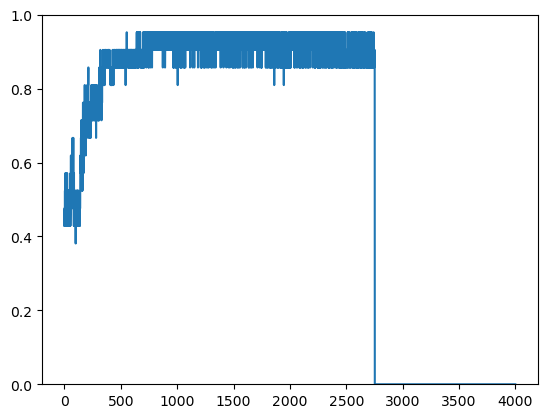

In [ ]:
nHiddenGAIL = 200
LRstr = '1e-4'
inputLenTime = 5
outputLenTime = 1

# GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr
# GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr
GAILConfigName = 'nH_' + str(nHiddenGAIL) + '_dS_' + str(dSampFactor) + '_LR_' + LRstr + '_iL_' + str(inputLenTime)

accHistory = np.load('./savedModels/varGAIL/logs/' + LSTMModelName + '_' + GAILConfigName + '_accHistory.npy')
print(GAILConfigName, accHistory.shape)
# with open('./savedModels/GAIL/logs/' + LSTMModelName + '_test_accHistory.npy', 'rb') as f:
#     accHistory = np.load(f)
# accHistory = np.load('./savedModels/GAIL/logs/' + LSTMModelName + '_test_accHistory.npy')

# accHistory[:300, -1]

plt.plot(accHistory[:4000, 3])
plt.ylim([0, 1])

tensor(992.9999, device='cpu') tensor(98.8982, device='cpu') tensor(992.9995, device='cpu') torch.Size([984, 90]) torch.Size([984, 90])


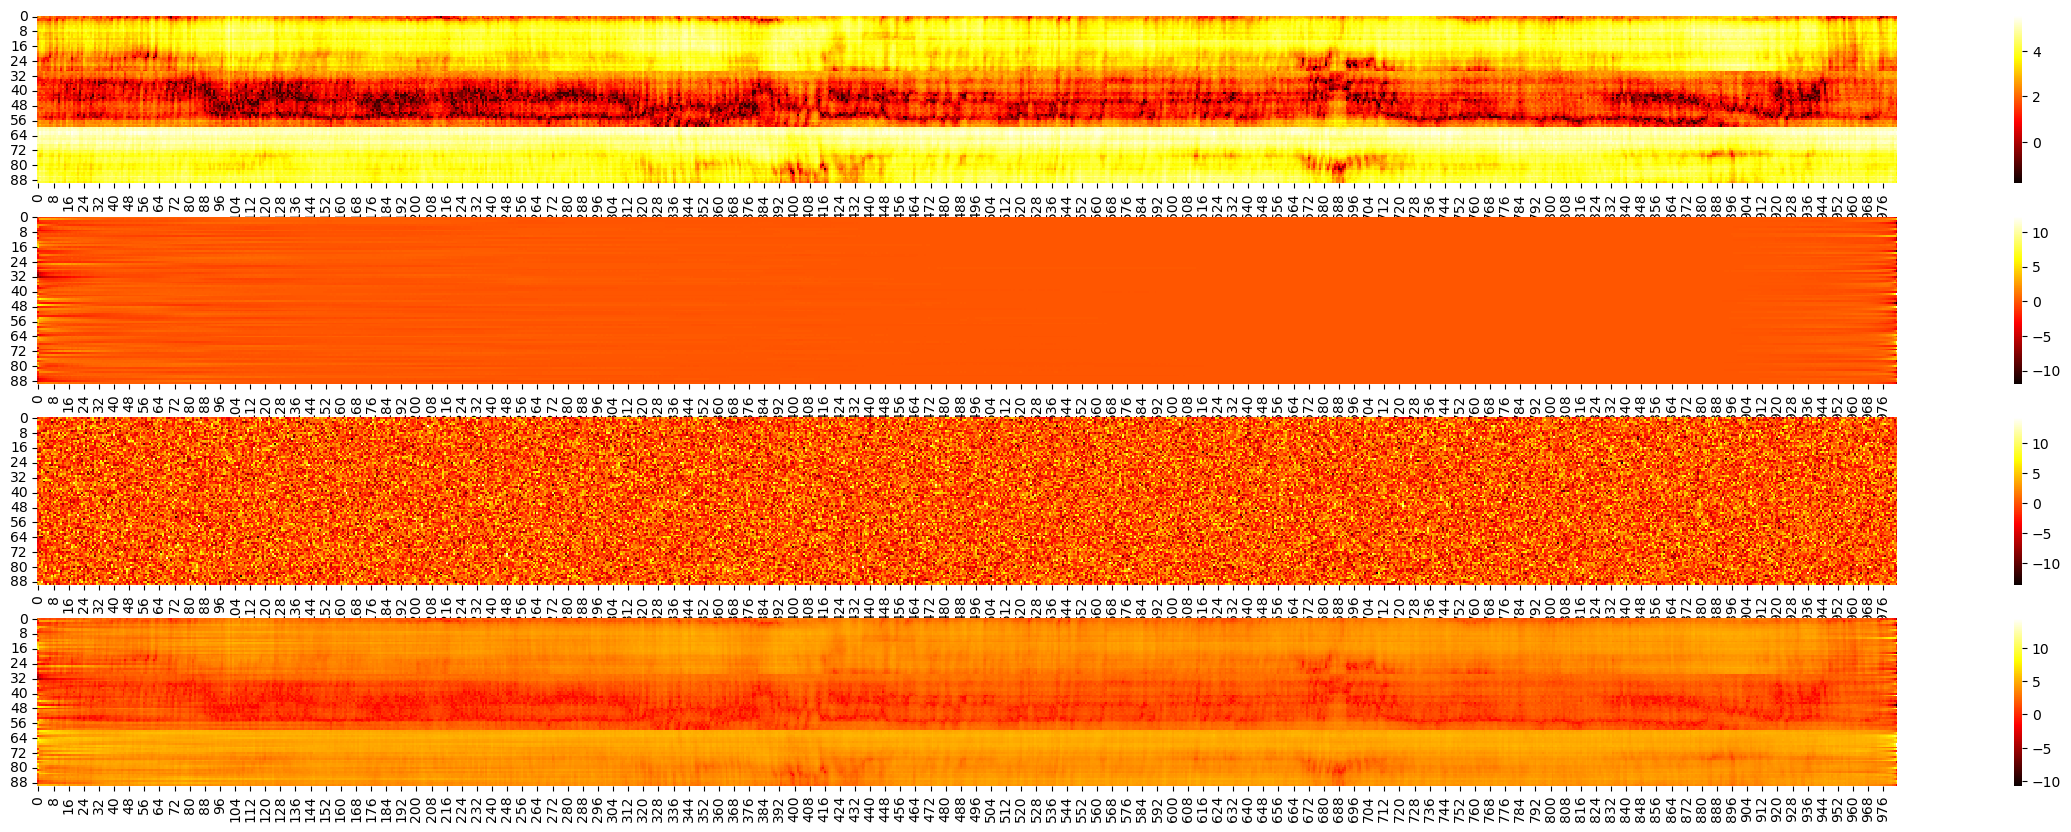

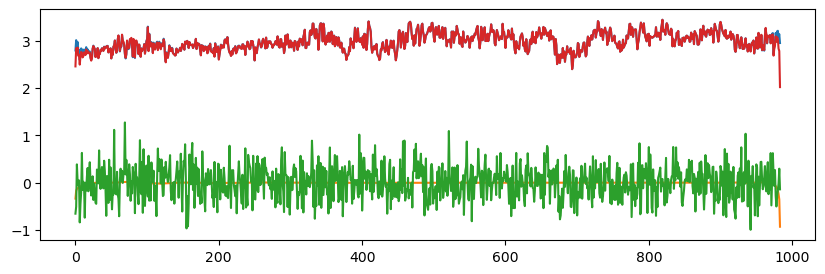

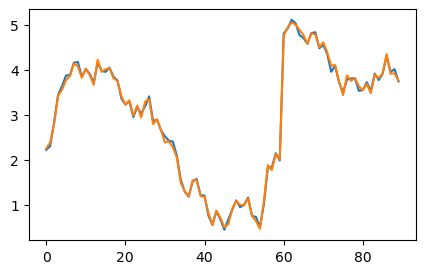

In [ ]:
import seaborn as sns

activity = 'walk'
dataIdx = 4
noise = torch.randn(dataDict[activity]['obs'][dataIdx][padLen:, :].shape).cpu()
noise = noise * LA.norm(dataDict[activity]['obs'][dataIdx]) / LA.norm(noise)
datawFGM = dataDict[activity]['obs'][dataIdx][padLen:, :] + dataDict[activity]['FGM'][dataIdx]

print(LA.norm(dataDict[activity]['obs'][dataIdx]), LA.norm(dataDict[activity]['FGM'][dataIdx]), LA.norm(noise), dataDict[activity]['obs'][dataIdx][padLen:, :].shape, dataDict[activity]['FGM'][dataIdx].shape)
plt.figure(0, figsize=(30,10))
plt.subplot(4,1,1)
sns.heatmap(torch.transpose(dataDict[activity]['obs'][dataIdx][padLen:, :], 0, 1), cmap='hot')

plt.subplot(4,1,2)
sns.heatmap(torch.transpose(dataDict[activity]['FGM'][dataIdx], 0, 1), cmap='hot')

plt.subplot(4,1,3)
sns.heatmap(torch.transpose(noise, 0, 1), cmap='hot')

plt.subplot(4,1,4)
sns.heatmap(torch.transpose(datawFGM, 0, 1), cmap='hot')


plt.figure(1, figsize=(10,3))
# plt.subplot(3,1,1)
plt.plot(torch.mean(dataDict[activity]['obs'][dataIdx][padLen:, :], dim=1).cpu())
plt.plot(torch.mean(dataDict[activity]['FGM'][dataIdx], dim=1).cpu())
plt.plot(torch.mean(noise, dim=1))
plt.plot(torch.mean(datawFGM, dim=1))

plt.figure(2, figsize=(5, 3))
plt.plot(torch.mean(dataDict[activity]['obs'][dataIdx][padLen:, :], dim=0).cpu())
plt.plot(torch.mean(datawFGM, dim=0).cpu())
# plt.plot(torch.mean(dataDict[activity]['FGM'][dataIdx], dim=0).cpu())
# plt.plot(torch.mean(noise, dim=0).cpu())

